In [1]:
import pandas as pd
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# this library is impoted to Supress the warning in the ABC analysis section. 

import warnings
warnings.filterwarnings("ignore")

In [3]:
#customers table import

df = pd.read_excel("customer.xlsx")

In [4]:
#data checking

df.head(5)

,Customer,Date,Sale,Quantity
0,cu-01,2020-01-01,3000,225.0
1,cu-01,2020-03-01,1500,113.0
2,cu-01,2020-04-01,3000,225.0
3,cu-01,2020-05-01,1450,108.5
4,cu-01,2020-06-01,30000,2250.0


In [5]:
#checking if there is any value missing in any of the column
df.isnull().any()

Customer    False
Date        False
Sale        False
Quantity    False
dtype: bool

---  There is no value missing in the table. We do not have to clean the data or fill the missing values. 

In [6]:
#Number of customers

df['Customer'].nunique()


30

In [7]:
#Number of months

df['Date'].nunique()

35

--- WE have total 30 customers and our sale covers 35 months of data. 

In [8]:
#grouped.plot.line(x='Date', y='Sale') 
#plt.show()

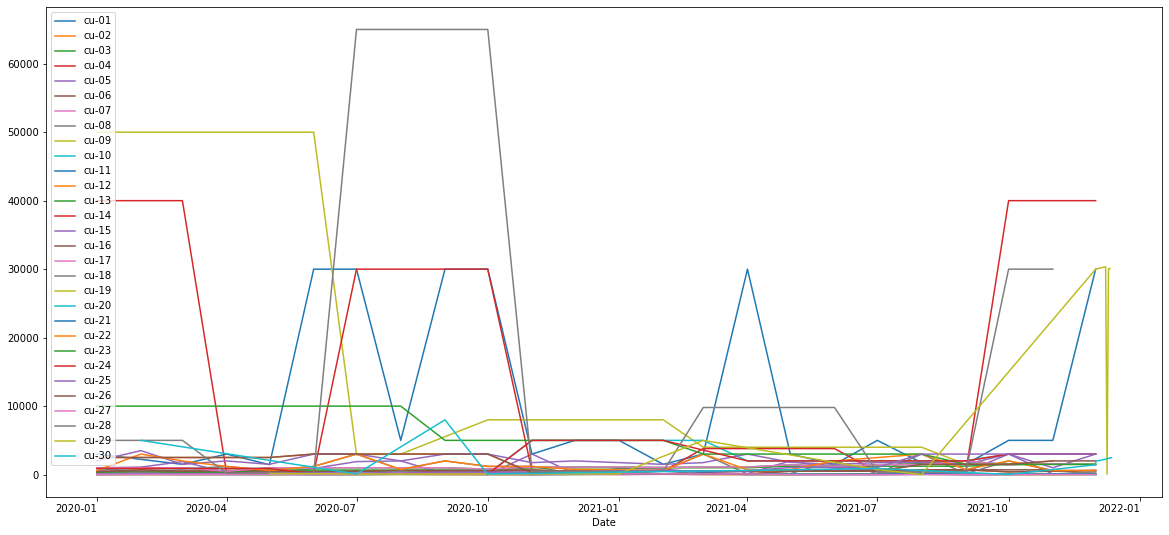

In [9]:
#Grouping(Pivot) by the customer and ploting the dates VS Sale 

plt.figure(figsize=(20,10))

df.set_index('Date', inplace=True)

df.groupby('Customer')['Sale'].plot(legend=True, rot=0)

plt.show()

In [10]:
df_group =  df.groupby('Customer').sum().sort_values(by=['Sale'], ascending=False)
df_group.head(2) 

,Sale,Quantity
Customer,,
cu-14,379000,28427.0
cu-28,378000,28352.0


# ABC Anlysis

For ABC analysis, we are going to split the customer into three importance catagory 20-30 and 50. 
 



Three Catagories 

A = 20,
B = 30,
C = 50.

In [11]:
#first we will define a function that will use the input data

def ABC_function(table):
    
    #grouping the values using customer ID and sorting based on the total sale to the customer. 
    df_group = df.loc[:, ['Customer','Sale']].groupby('Customer').sum().sort_values(by=['Sale'], ascending=False)
    
   
    #Next Ranking the customers based on the sale. And creating a new column Rank based on the ranking

    df_group["Rank_abc"] = df_group['Sale'].rank(ascending = False)

    # spliting the customers into calss A, B and C based on the ranking. e.g top 20% will go to calss A, next 30# will be class B
    # and last 50% will be calss C

    #Placed class A,B and C into column Category
    df_group['Category'] = '' # creating an empty column


    df_group['Category'][0: int(0.2 * df_group['Rank_abc'].max())] = 'A'
    df_group['Category'][int(0.2 * df_group['Rank_abc'].max()) : int(0.5 * df_group['Rank_abc'].max())] = 'B'
    df_group['Category'][int(0.5 * df_group['Rank_abc'].max()):] = 'C'

    return df_group  #ABC analysis

In [12]:
# now putting the customer table values in the function

ABC_analysis = ABC_function(df)

ABC_analysis.head()

,Sale,Rank_abc,Category
Customer,,,
cu-14,379000,1.0,A
cu-28,378000,2.0,A
cu-09,375900,3.0,A
cu-29,307784,4.0,A
cu-01,234200,5.0,A


A     6
B     9
C    15
Name: Category, dtype: int64

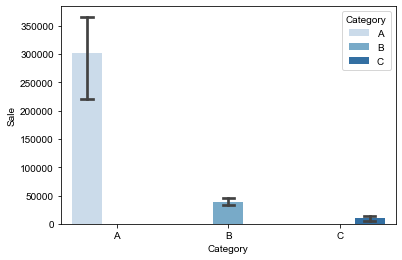

In [13]:
sns.barplot(x = 'Category', y = 'Sale',data = ABC_analysis, hue='Category', capsize=0.1, palette = "Blues")
sns.set_theme(style="whitegrid")



ABC_analysis['Category'].value_counts(ascending=True)

# Pareto analysis for ABC_Analysis Data

In [14]:
#-----Lets perform Pareto analysis to see if top 20% customers are contributing 80% or closer to sale.

In [15]:
# converting Sale into percentage

ABC_analysis2 =pd.DataFrame(round(ABC_analysis.groupby('Category')['Sale'].sum() / ABC_analysis['Sale'].sum()*100)).reset_index()
Cat_percent = ['20','30','50']  # values of A, B and C that we used for ABC analysis

ABC_analysis2['Cat_percent'] = Cat_percent
ABC_analysis2['Cat_percent'] = ABC_analysis2['Cat_percent'].astype(int)
ABC_analysis2.head()


,Category,Sale,Cat_percent
0,A,78.0,20
1,B,15.0,30
2,C,6.0,50


In [16]:
ABC_analysis2['Sale']

0    78.0
1    15.0
2     6.0
Name: Sale, dtype: float64

*** Above analysis clearly sjows that the 80-20 rule of Pareto is still valid with this data, the top 20% of the customers contribute almost 80% of the Sale share.***

**** Paretor Analysis is performed in the following chart****

Text(0, 0.5, 'Sale by percentage')

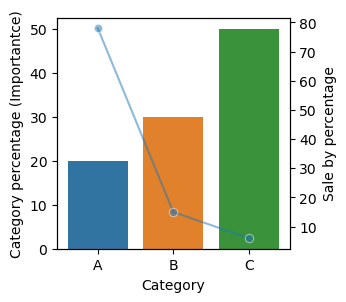

In [31]:
matplotlib.rc_file_defaults()
ax1 = sns.set_style(style=None, rc=None )

fig, ax1 = plt.subplots(figsize=(3,3))

sns.barplot(data = ABC_analysis2, x='Category', y='Cat_percent', ax=ax1)
ax1.set_ylabel( "Category percentage (Importantce)" )


ax2 = ax1.twinx()

sns.lineplot(data = ABC_analysis2, x='Category', y='Sale',  marker = "o", sort = False, alpha=0.5, ax=ax2)
ax2.set_ylabel( "Sale by percentage" )



--**** Category A that repensents the top 20% of the customers also showing that they contribute almost 80% of the sale. The Pareto analysis stands true for ABC analysis. *****


***-------------------------------------------------------------------***

***-------------------------------------------------------------------***

# XYZ Analysis using ARIMA model

Next we will perform XYZ analysis


We will be using ARIMA library to train the model. This model is used for future prediction. It will pridict the variablity in X , Y and Z factoors

In [18]:
df = pd.read_excel("customer.xlsx")

In [19]:
# Importing PRIMA library 

import pmdarima as pm
from pmdarima.model_selection import train_test_split

We will use MAPE (mean absolute percentage error) equation to evalute the forecat error. 
(Error between actual and predicted value from PRIMA model)

The MAPE is commonly used to measure the predictive accuracy of models. It is calculated as:

MAPE = (1/n) * Σ(|actual – prediction| / |actual|) * 100

In [20]:
#Defining MAPE as  ERROR function

def MAPE_ERROR(y_actual,y_predicted):
    mape = np.mean(np.abs((y_actual - y_predicted)/y_actual))*100
    return mape

next we will be defining a function for XYZ analysis using ARIMA model and also use the MAPE equation in it. 

In [21]:
def XYZ_arima(table):
    
    XYZ_values = []

# data is conervted into Time Series (Date) using Date column and quanity column. it is grouped by the customer name. 

    for grouped, parm in table.groupby(['Customer']):
        df_group = ( parm.loc[:, ['Date','Quantity']].set_index('Date')  )

    # splitig the data into training and testing purpose and only 16 will be used for testing 
        train, test = train_test_split(df_group, train_size=16)  

        # SInce data is seasonal and m shows the number of seasons  m = 4 means quarterly. 
        model = pm.auto_arima(train, seasonal=True, m=4)   

        #Now using the above model for prediction and using the training values
        
        predictions = model.predict(test.shape[0])  # predict N steps into the future
        
        #applying the MAPE function to calculate the mean absolute percentage error
        error = MAPE_ERROR(test.values.reshape(1,-1)[0], predictions)
        
        # combining the MAPE values with the Time series data, based on the customer               
        XYZ_values.append([grouped, error])        
              
         # combining XYZ values with error, customers, quantity and sale
    XYZ_param = pd.DataFrame(XYZ_values, columns = ['Customer', 'MAPE_ERROR'])
    XYZ_param = XYZ_param.sort_values(by=['MAPE_ERROR'], ascending=True)   #Re-arranging based on MAPE values
    
        ## Ranking based on the prediction
    XYZ_param["Rank_xyz"] = XYZ_param['MAPE_ERROR'].rank(ascending = True)
    XYZ_param["Prediction"] = ' '
    
        ## Checking the Importance of the Customers and Categorising into class X,Y,Z and splitting based on 20-30-50
    XYZ_param["Prediction"][0: int(0.2 * XYZ_param['Rank_xyz'].max())] = 'X'
    XYZ_param["Prediction"][int(0.2 * XYZ_param['Rank_xyz'].max()) : int(0.5 * XYZ_param['Rank_xyz'].max())] = 'Y'
    XYZ_param["Prediction"][int(0.5 * XYZ_param['Rank_xyz'].max()): ] = 'Z'
    
    return XYZ_param

In [22]:
XYZ_analysis = XYZ_arima(df)
XYZ_analysis .head()

,Customer,MAPE_ERROR,Rank_xyz,Prediction
12,cu-13,9.527529,1.0,X
1,cu-02,14.869450,2.0,X
16,cu-17,17.611212,3.0,X
2,cu-03,19.735422,4.0,X
15,cu-16,21.505709,5.0,X


Text(0, 0.5, 'Counts')

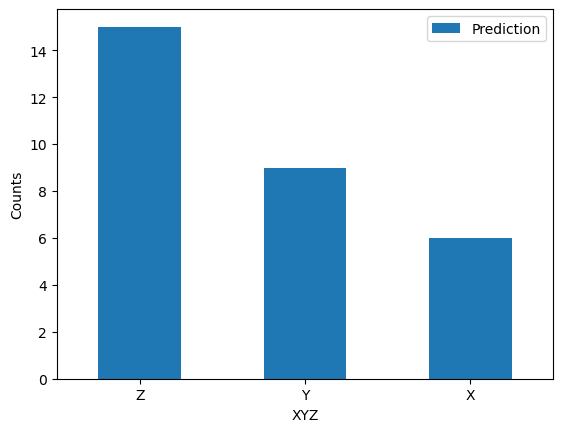

In [23]:
count_XYZ = XYZ_analysis['Prediction'].value_counts()
count_XYZ.plot.bar(legend=True, rot=0)

plt.xlabel('XYZ')
plt.ylabel('Counts')

In [33]:
abc_xyz = pd.merge(XYZ_analysis, ABC_analysis, on='Customer', how='inner').iloc[:,[0,4,6,3,1,5,2]]
abc_xyz.head()

,Customer,Sale,Category,Prediction,MAPE_ERROR,Rank_abc,Rank_xyz
0,cu-13,21982,C,X,9.527529,18.0,1.0
1,cu-02,12600,C,X,14.869450,22.0,2.0
2,cu-17,27850,B,X,17.611212,14.0,3.0
3,cu-03,26570,B,X,19.735422,15.0,4.0
4,cu-16,13300,C,X,21.505709,20.0,5.0


Comparison of ABC analysis with XYZ analysis

<AxesSubplot:xlabel='Prediction', ylabel='Category'>

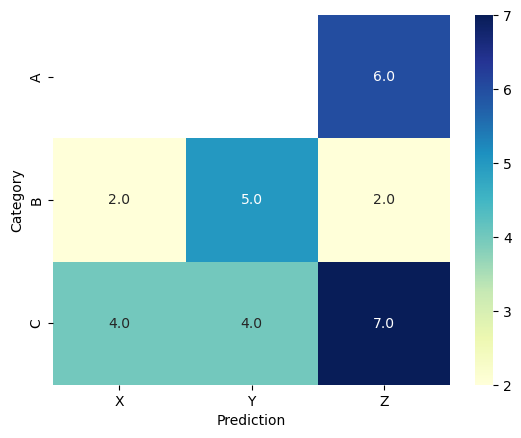

In [25]:
ABC_XYZ = abc_xyz.groupby(['Category', 'Prediction']).count()

result = ABC_XYZ.pivot_table(index = 'Category', columns= 'Prediction', values= 'Customer')

sns.heatmap(result, annot = True, fmt = '', cmap = "YlGnBu")

The above ABC-XYZ analysis shows the distribution of 30 of our customers. This data is showing lot of room of improvments,to have values in AX. Please see below the examples taken from abcsupplychain.com 

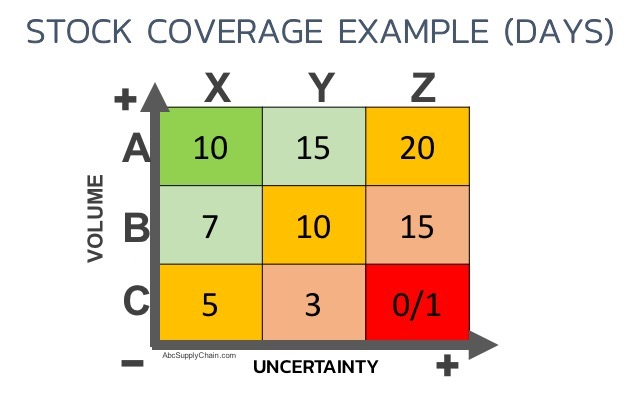

In [41]:
from IPython import display
display.Image("ABC-XYZ.jpg")

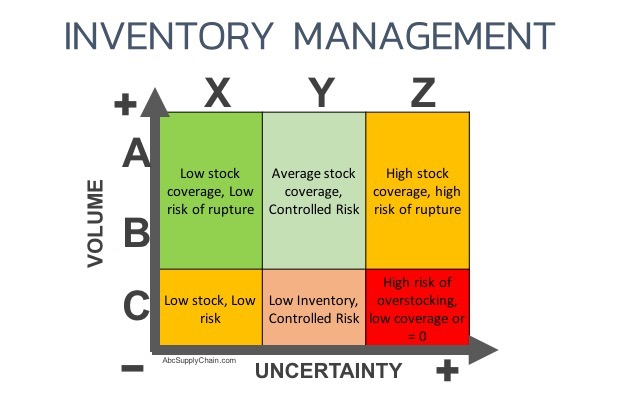

In [42]:
 display.Image("ABC-XYZ2.jpg")